In [1]:
import os
from glob import glob
import pickle

import numpy as np
import pandas as pd

import nltk
import re
import codecs
import unidecode
#pip install unidecode
import mpld3
# pip install mpld3
import stop_words
# pip install stop-words
from nltk import SnowballStemmer, pos_tag, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import HashingVectorizer,TfidfTransformer,TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import *
#from sklearn.semi_supervised import *
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import confusion_matrix, classification_report

** Lecture des données **

In [6]:
#download cv in a list
def load_cv_list(nombre):
    path = '../Maha/data/Txt/'
    liste_paths = [path+directory for directory in os.listdir(path)]
    liste_cv = []
    liste_files = []
    for path in liste_paths :
        #if "informaticien" and "dba" and "chef_de_projet_informatique" not in path:
        filenames = sorted(glob(os.path.join(path,"*.txt")))
           
        for file in filenames[:nombre]:
            liste_cv.append(open(file).read())
            liste_files.append(file)
    return liste_cv,liste_files

In [7]:
liste_cv_indeed,liste_files = load_cv_list(700)

In [8]:
print(len(liste_cv_indeed), "cvs")

6452 cvs


In [9]:
liste_files_sub = [cvName.split('/')[-1][0:-4] for cvName in liste_files  ]
cv_names = liste_files_sub
print(len(cv_names),"cv names")


6452 cv names


In [10]:
liste_cv_indeed[0]

"Administrateur réseaux et sécurité\n\nNanterre (92) - Email me on Indeed: indeed.com/r/38feb844e66fc577\n\nEXPÉRIENCE\n\nAdministrateur réseaux et sécurité\n\nIT Delivery Services  -  Paris (75) -\n\naoût 2017 - novembre 2017\n\nIT Delivery Services – Administrateur Réseau et Sécurité\nParis\nMission chez ATOS : Administration des Pare-feu (Fortigate 5000 et 1500)\n〓 Piloter un projet de migration de 70 VDOM\n〓 Etude de l’existant et préparation des schémas cible\n〓 Création de la matrice de flux\n〓 Mettre en place un plan d’adressage, VLAN et Routage\n〓 Upgrade des FortiOS\n〓 Analyse et comparaison les fichiers de configuration\n〓 Résolution des problèmes technique.\n〓 Analyse de risque et création des modes opératoires de Migration\n\nAdministrateur systèmes, réseaux et virtualisation\n\nAtento (Intelcia)  -  Casablanca -\n\nnovembre 2006 - mai 2017\n\n-Réseau (Switch, Routeur, firewall) (Cisco, Dell, HP, Fortigate, Peplink)\n〓 Configuration et attribution des adresses IP, VLAN, VPN

In [11]:
# Read CV labels 
def read_labels(fileName):
    xl = pd.ExcelFile(fileName)
    df_labels = xl.parse("Feuil1")
    print("Nb of labeled CV", df_labels[df_labels['CV_Label']!=-1].count())
    print("Nb of unlabeled CV", df_labels[df_labels['CV_Label']==-1].count())
    print("Total Nb of CV ", df_labels.count())
    return df_labels


In [12]:
df_labels = read_labels('./Data_label/indeed/CV_labels.xlsx')
df_labels

Nb of labeled CV CV_name     121
CV_Label    121
dtype: int64
Nb of unlabeled CV CV_name     133
CV_Label    133
dtype: int64
Total Nb of CV  CV_name     254
CV_Label    254
dtype: int64


,CV_name,CV_Label
0,cv_Administrateur Base Donnees_1,2
1,cv_Administrateur Base Donnees_2,2
2,cv_Administrateur Base Donnees_3,1
3,cv_Administrateur Base Donnees_4,1
4,cv_Administrateur Base Donnees_5,1
5,cv_Administrateur Base Donnees_6,2
6,cv_Administrateur Base Donnees_7,2
7,cv_Administrateur Base Donnees_8,-1
8,cv_Administrateur Base Donnees_9,2
9,cv_Administrateur Base Donnees_10,2


### Cleaning fonctions

#### Suppression des sauts de ligne

In [13]:
import string,re

In [14]:
regex = re.compile('[%s]' % '(\\n)*(\\x0c)*')
def del_line_feed(s):  
    """Delete \n in the text"""
    return regex.sub(' ', s)

In [15]:
liste_cv_indeed = [del_line_feed(text).lower() for text in liste_cv_indeed]

In [16]:
liste_cv_indeed[0]

"administrateur réseaux et sécurité  nanterre  92  - email me on indeed: indeed.com/r/38feb844e66fc577  expérience  administrateur réseaux et sécurité  it delivery services  -  paris  75  -  août 2017 - novembre 2017  it delivery services – administrateur réseau et sécurité paris mission chez atos : administration des pare-feu  fortigate 5000 et 1500  〓 piloter un projet de migration de 70 vdom 〓 etude de l’existant et préparation des schémas cible 〓 création de la matrice de flux 〓 mettre en place un plan d’adressage, vlan et routage 〓 upgrade des fortios 〓 analyse et comparaison les fichiers de configuration 〓 résolution des problèmes technique. 〓 analyse de risque et création des modes opératoires de migration  administrateur systèmes, réseaux et virtualisation  atento  intelcia   -  casablanca -  novembre 2006 - mai 2017  -réseau  switch, routeur, firewall   cisco, dell, hp, fortigate, peplink  〓 configuration et attribution des adresses ip, vlan, vpn  ssl & ipsec , stp, vrrp, rout

#### Suppression ponctuation

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
#le maintient de la ponctuation pertube le stop words, apostrophe gérée dans text_treatment
regex = re.compile('[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_{|}~')) 

def del_punct(s):  
    """Delete punctuation in the text"""
    return regex.sub('', s)

In [19]:
#test 
liste_cv_indeed_no_punc = [del_punct(text) for text in liste_cv_indeed]

In [20]:
liste_cv_indeed_no_punc[0]

"administrateur réseaux et sécurité  nanterre  92   email me on indeed indeedcomr38feb844e66fc577  expérience  administrateur réseaux et sécurité  it delivery services    paris  75    août 2017  novembre 2017  it delivery services – administrateur réseau et sécurité paris mission chez atos  administration des parefeu  fortigate 5000 et 1500  〓 piloter un projet de migration de 70 vdom 〓 etude de l’existant et préparation des schémas cible 〓 création de la matrice de flux 〓 mettre en place un plan d’adressage vlan et routage 〓 upgrade des fortios 〓 analyse et comparaison les fichiers de configuration 〓 résolution des problèmes technique 〓 analyse de risque et création des modes opératoires de migration  administrateur systèmes réseaux et virtualisation  atento  intelcia     casablanca   novembre 2006  mai 2017  réseau  switch routeur firewall   cisco dell hp fortigate peplink  〓 configuration et attribution des adresses ip vlan vpn  ssl  ipsec  stp vrrp routage  statique et dynamique  n

** Reconnaissance du langage du CV**

In [21]:
def _calculate_languages_ratios(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    """

    languages_ratios = {}

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
    >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens] #from text get list of word in minuscule

    
    for language in stopwords.fileids(): # pour chaque langue
        stopwords_set = set(stopwords.words(language)) #je mets les stop words du langage dans un set
        words_set = set(words) #je mets les mots de mon texte dans un set
        #je prends l'intersection entre les mots de mon texte et les mots du stopwords dans le langage donné
        common_elements = words_set & stopwords_set
        
        #je compute mon score comme le nombre d'éléments en communs dictionnaire [langage : score]
        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

In [22]:
import nltk
nltk.download('stopwords')
stopwords.fileids()

[nltk_data] Downloading package stopwords to /Users/maha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['arabic',
 'azerbaijani',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish',
 'turkish']

In [23]:
def get_cv_langue(liste_cv, language,cv_names) :
    """Return resume witten in the specified language in parameter"""
    liste_2 = []
    french_cv_names = []
    i=0
    for cv in liste_cv:
        if max(_calculate_languages_ratios(cv),key =_calculate_languages_ratios(cv).get)=='french':
            liste_2.append(cv)
            french_cv_names.append(cv_names[i])
        i+=1
    return liste_2,french_cv_names

In [24]:
liste_cv_indeed_fr, cv_fr_names = get_cv_langue(liste_cv_indeed_no_punc,'french',cv_names)

In [25]:
nb_cv = len(liste_cv_indeed_no_punc)
nb_cv_fr = len(liste_cv_indeed_fr)

print("proportion cv french :",1- ((nb_cv-nb_cv_fr)/nb_cv))


proportion cv french : 0.736515809051457


** Preprocessing du text **

In [26]:
def text_treatment (text):
    text = text.lower()
    text = text.replace("\x00", '').replace("\x01", '').replace("\x02", '').replace("\x03", '') \
    .replace("\x04", '').replace("\x05", '').replace("\x06", '').replace("\x07", '').replace("\x08", '') \
    .replace("\x0e", '').replace("\x11", '').replace("\x12", '').replace("\x10", '').replace("\x19", '') \
    .replace("\x1b", '').replace("\x14", '').replace("\x15", '').replace('/', '').replace('=', '').replace("〓", "") \
    .replace("»", "").replace("«", "").replace("¬", "").replace('`', '').replace (" -", "").replace("•", "")\
    .replace("l'", "").replace("l’", "").replace("l´", "").replace("d’", "").replace("d'", "").replace("d´","")\
    .replace("j’", "").replace("j'", "").replace("j´","").replace("n’", "").replace("n'", "").replace("n´","")\
    .replace("”", "").replace("~", "").replace("§", "").replace("¨", "").replace("©", "").replace("›", "")\
    .replace("₋", "").replace("→", "").replace("⇨", "").replace("∎", "").replace("√", "").replace("□", "")\
    .replace("*", "").replace("&", "").replace("►", "").replace("◊", "").replace("☞", "").replace("#", "")\
    .replace("%", "").replace("❖", "").replace("➠", "").replace("➢", "").replace("", "").replace("✓", "") \
    .replace("√", "").replace("✔", "").replace("♦", "").replace("◦", "").replace("●", "").replace("▫", "")\
    .replace("▪", "").replace("…", "").replace("þ", "").replace("®", "").replace('', '').replace("...", "")
    text = unidecode.unidecode(text) # remove accent
    return text

In [27]:
#On supprime les caractères étranges, accents et stop words
liste_cv_indeed_treated = [text_treatment(text) for text in liste_cv_indeed_fr]

In [28]:
#test
liste_cv_indeed_treated[0]

'administrateur reseaux et securite  nanterre  92   email me on indeed indeedcomr38feb844e66fc577  experience  administrateur reseaux et securite  it delivery services    paris  75    aout 2017  novembre 2017  it delivery services - administrateur reseau et securite paris mission chez atos  administration des parefeu  fortigate 5000 et 1500   piloter un projet de migration de 70 vdom  etude de existant et preparation des schemas cible  creation de la matrice de flux  mettre en place un plan adressage vlan et routage  upgrade des fortios  analyse et comparaison les fichiers de configuration  resolution des problemes technique  analyse de risque et creation des modes operatoires de migration  administrateur systemes reseaux et virtualisation  atento  intelcia     casablanca   novembre 2006  mai 2017  reseau  switch routeur firewall   cisco dell hp fortigate peplink   configuration et attribution des adresses ip vlan vpn  ssl  ipsec  stp vrrp routage  statique et dynamique  nat et les acl

** Gestion des stop words **

In [29]:
#generate stopwords
stop_words_py = set(stop_words.get_stop_words('french'))

# attention certains stop words pourraient être utiles par la suite
stopwords_set_manuel = set(["an", "ans", 'les', 'moins', 'd\'un','janvier', 'fevrier', 'février', 'mars', 'avril', \
                 'mai', 'juin', 'juillet', 'aout', 'août', 'septembre', 'octobre', 'novembre', 'décembre', \
                  'decembre', 'moins', 'mise', 'universit\xc3\xa9', 'université', 'universite', 'ion','sage', \
                  'o', 'rac', 'vers', 'via', 'p\xc3\xa9rim\xc3\xa8tre', 'périmètre','et','paris','x',"\x00",\
                          "\x01","\x02", "\x03","\x04","\x05","\x06","\x07","\x08","\x09","\x0e","\x0e","\x11",\
                           "\x12","\x13","\x14","\x15","\x16","\x17","\x18","\x19","transport","puis","lieu",\
                           "adresse","entre",'dun','dune','chez','boulognebillancourt','bt','etc','recrutement','main',\
                           'and', 'paie','paiement','environ','place','france','paris','mois','mobile','mobiles',\
                           'nanterre','source','sources','concerne','concernant','of','non','notes','rh','minimum',\
                           'maximum','bac','site','sites','actuellement','telephone','telephonique','telephoniques','ca','demenager',\
                           'demenagement','participer','participation','lycee','baccalaureat','lien','liens','in',\
                           'indeed','email','indeedcomrd7e8913ed00d0384','aujourhui','afin','toujours','enterprise',\
                           "guide","10g","11g","9i",'ad','v10','v2','v3','v5','v6','v8','v9',])
stop_words_main = stop_words_py | stopwords_set_manuel
stop_words_main = list(stop_words_main)
print("taille stop words liste : ", len(stop_words_main))

taille stop words liste :  368


In [30]:
stop_words_main

['faites',
 'fusses',
 'devrions',
 'aviez',
 'nommés',
 'depuis',
 'fait',
 'sommes',
 'nom',
 'même',
 'v6',
 'paris',
 'eux',
 'autre',
 "d'un",
 'avait',
 'fussiez',
 'telephonique',
 'êtes',
 'aies',
 'ai',
 'comment',
 '\x05',
 'aucun',
 'dans',
 'enterprise',
 'le',
 'decembre',
 'lien',
 'car',
 'si',
 'eusses',
 'avec',
 'leur',
 'eusse',
 'les',
 'serais',
 'd',
 'soyez',
 'juin',
 'v8',
 'dedans',
 'of',
 'universite',
 'via',
 'voit',
 'ici',
 'aurais',
 'seront',
 'eussiez',
 'tellement',
 'où',
 'devoir',
 'avant',
 'avions',
 'ton',
 'novembre',
 'octobre',
 '\x16',
 'place',
 'aurait',
 'eus',
 'tandis',
 'aurions',
 'etc',
 'étés',
 'se',
 '\x00',
 'dehors',
 'mes',
 'droite',
 'elles',
 'y',
 'fus',
 '\x06',
 'fut',
 'toujours',
 'pour',
 'moi',
 'ces',
 'j',
 'devront',
 'valeur',
 'lycee',
 'moins',
 'du',
 'mai',
 'nommée',
 'notre',
 'à',
 'as',
 '\x13',
 'avoir',
 'environ',
 'ayons',
 'eûmes',
 'ta',
 '\x01',
 'eue',
 'main',
 'in',
 'aient',
 'mot',
 '\x0e',
 '

In [31]:
#voir si utile
def remove_stopwords(text,stopwords_list):
    text_temp = " ".join(text.split())+" "
    for word in stopwords_list:
        text_temp = text_temp.replace(" "+word+" ", " ")
    return text_temp

In [32]:
#test 
liste_cv_indeed_no_stop = [remove_stopwords(text,stop_words_main) for text in liste_cv_indeed_treated]

In [33]:
liste_cv_indeed_no_stop[0]

'administrateur reseaux securite 92 indeedcomr38feb844e66fc577 experience administrateur reseaux securite it delivery services 75 2017 2017 it delivery services - administrateur reseau securite mission atos administration parefeu fortigate 5000 1500 piloter projet migration 70 vdom etude existant preparation schemas cible creation matrice flux mettre plan adressage vlan routage upgrade fortios analyse comparaison fichiers configuration resolution problemes technique analyse risque creation modes operatoires migration administrateur systemes reseaux virtualisation atento intelcia casablanca 2006 2017 reseau switch routeur firewall cisco dell hp fortigate peplink configuration attribution adresses ip vlan vpn ssl ipsec stp vrrp routage statique dynamique nat acls supervision bande passante erreurs discards etat ports solarwinds application mises jour firmware administration coeur reseau cisco catalyste 4507 dell force10 c150 sauvegarde restauration configurations parametrage logs syslog 

In [34]:
#SnowballStemmer 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("french")

In [35]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters 
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters 
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [36]:
totalvocab_indeed_stemmed = []
totalvocab_indeed_tokenized = []
for text in liste_cv_indeed_no_stop:
    allwords_stemmed = tokenize_and_stem(text) #for each item in 'synopses', tokenize/stem
    totalvocab_indeed_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(text)
    totalvocab_indeed_tokenized.extend(allwords_tokenized)

In [37]:
vocab_frame_indeed = pd.DataFrame({'words': totalvocab_indeed_tokenized}, index = totalvocab_indeed_stemmed)
print('there are ' + str(vocab_frame_indeed.shape[0]) + ' items in vocab_frame')
vocab_frame_indeed

there are 1003403 items in vocab_frame


,words
administr,administrateur
reseau,reseaux
securit,securite
indeedcomr38feb844e66fc577,indeedcomr38feb844e66fc577
experient,experience
administr,administrateur
reseau,reseaux
securit,securite
it,it
delivery,delivery


In [38]:
vocab_frame_indeed.loc['in']

,words
in,ins
in,ins


HashVectorizer -> Normalize Documents Vectors

### BOW - IDF

In [39]:
def get_Bow_IDF(liste_cv):
    tf_vect = TfidfVectorizer(stop_words=stop_words_main,max_df=0.8,min_df=0.05,\
                               preprocessor=text_treatment,tokenizer=tokenize_and_stem)
    bow_idf = tf_vect.fit_transform(liste_cv)
    vocab = tf_vect.get_feature_names()
    return bow_idf,vocab

bow_idf_indeed, _  = get_Bow_IDF(liste_cv_indeed_no_stop)
print(bow_idf_indeed.toarray())
print(bow_idf_indeed.shape)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.05518292  0.          0.         ...,  0.          0.          0.24441255]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.05062269  0.          0.         ...,  0.          0.          0.05605367]
 [ 0.          0.          0.06646684 ...,  0.          0.          0.        ]]
(4752, 480)


### BOW- LSA

In [40]:
#implement LSA
def get_Bow_LSA(bow,lsa_dim):
 
    svd = TruncatedSVD(lsa_dim)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    bow_reduced_lsa = lsa.fit_transform(bow)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    return bow_reduced_lsa

bow_idf_reduced_lsa = get_Bow_LSA(bow_idf_indeed, lsa_dim = 150)
print(bow_idf_reduced_lsa) 
print(bow_idf_reduced_lsa.shape)


Explained variance of the SVD step: 68%
[[ 0.44848819  0.41153945 -0.32905038 ...,  0.06978115 -0.03667167
   0.02478443]
 [ 0.37562229  0.33455958 -0.14697444 ...,  0.0193808  -0.04450632
  -0.00524698]
 [ 0.45803658  0.23646886 -0.2789277  ..., -0.10198457  0.04145881
  -0.07337786]
 ..., 
 [ 0.45758454 -0.10603175 -0.23074332 ..., -0.03761285  0.01863657
  -0.02070233]
 [ 0.36519581  0.37680815 -0.30525582 ...,  0.04342208  0.02930152
  -0.02070251]
 [ 0.44543819 -0.12876204 -0.03658326 ...,  0.0470131  -0.04390859
   0.01055947]]
(4752, 150)


### BOW- NMF 

In [41]:

#implement NMF


def get_Bow_NMF(bow,nmf_number):
 
    nmf = NMF(n_components=nmf_number).fit(bow) 
    l2_norm = Normalizer()
    #get text matrix in nmf topic space
    bow_idf_reduced_nmf = nmf.fit_transform(bow)
    bow_idf_reduced_nmf_normalized = l2_norm.fit_transform(bow_idf_reduced_nmf) #l2 observation normalization
    
    return bow_idf_reduced_nmf_normalized, 

bow_idf_reduced_nmf_normalized = get_Bow_NMF(bow_idf_indeed, nmf_number = 150)
print(bow_idf_reduced_nmf_normalized) 


(array([[ 0.21274078,  0.63452342,  0.        , ...,  0.01997223,
         0.        ,  0.00685944],
       [ 0.        ,  0.20892066,  0.        , ...,  0.        ,
         0.        ,  0.69141582],
       [ 0.01931123,  0.        ,  0.        , ...,  0.01480247,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.10842977,  0.00591593],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.07417507],
       [ 0.34250884,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]),)


### SEMI-SUPERVISED - Data Preparation 

In [42]:
# this is for preparing the target dataframe that will be used to build the input of semi-supervised model
# cv_fr_name contains CV names in the same order as the bag of words in bow array
# df_labels dataframe containing label for each cv_name.
# cv_name is used for jointure between df_labels and bow

def prepare_bow_with_labels(bow,cv_fr_names,df_labels):
    bow_cv_names = np.c_[bow, cv_fr_names]
    buffer_= pd.DataFrame(data=bow_cv_names)
    #print('count data before drop duplicate:', buffer_.count())
    #buffer_.drop_duplicates(inplace=True)
    #column_names = buffer_.columns.values[:-1].tolist()
    #buffer_.duplicated(subset=column_names)

    #buffer_.drop_duplicates(subset=column_names, keep=False,inplace=True)
    #bow_idf_indeed_ = buffer_.values
    #print('count data after drop duplicate:', buffer_.count())
    buffer_.rename(columns={buffer_.shape[1]-1 : 'CV_name'},inplace=True)
    df_target = buffer_.join(df_labels.set_index('CV_name'), on='CV_name')
    print('CV count :', df_target.shape[0])
    print('After jointure: Nb CV without any label:', df_target.CV_Label.isnull().sum())

    df_target.fillna(-1,inplace=True)
    df_target['CV_Label'] = df_target['CV_Label'].astype(int)
    print('After jointure: Nb CV with label :', df_target[df_target['CV_Label'] != -1].shape[0])
    print('After jointure: Nb CV with label= -1:', df_target[df_target['CV_Label'] == -1].shape[0])
    return df_target


### SEMI-SUPERVISED - LabelSpreading

In [43]:
# trainEval_semi_supervisedModel entraine le modèle sur les n_labeledPoints (donné en paramètre) CVs  
# la fonction evalue le modèle ensuite sur le reste des données (len(target) - n_labeledPoints)
# data contient X (bow labélisés) et target Y ( labels)

def trainEval_semi_supervisedModel(data,target,n_labeledPoints):
    

    rng = np.random.RandomState(0)
    indices = np.arange(len(data))
    rng.shuffle(indices)


    X = data[indices[:len(data)]]
    y = target[indices[:len(data)]]


    n_total_samples = len(y)
    n_labeled_points = n_labeledPoints

    indices = np.arange(n_total_samples)
    unlabeled_set = indices[n_labeled_points:]

    ##############################################################################

    y_train = np.copy(y)
    y_train[unlabeled_set] = -1

    ##############################################################################
    # Learn with LabelSpreading
    #0, 0.5, 07, 1
    lp_model = label_propagation.LabelSpreading(alpha = 0.2)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_set]
    true_labels = y[unlabeled_set]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
          (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    
    return lp_model



In [44]:
# trainEval_semi_supervisedModel entraine le modèle sur les n_labeledPoints (donné en paramètre) CVs  
# la fonction evalue le modèle ensuite sur le reste des données (len(target) - n_labeledPoints)
# data contient X (bow labélisés) et target Y ( labels)

def trainEval_semi_supervisedModel(data,target, n_labeledPoints):
    

    rng = np.random.RandomState(0)
    indices = np.arange(len(data))
    rng.shuffle(indices)


    X = data[indices[:len(data)]]
    y = target[indices[:len(data)]]


    n_total_samples = len(y)
    n_labeled_points = n_labeledPoints

    indices = np.arange(n_total_samples)
    unlabeled_set = indices[n_labeled_points:]

    ##############################################################################

    y_train = np.copy(y)
    y_train[unlabeled_set] = -1

    ##############################################################################
    # Learn with LabelSpreading
    #0, 0.5, 07, 1
    lp_model = label_propagation.LabelSpreading(alpha = 0.2)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_set]
    true_labels = y[unlabeled_set]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
          (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    
    return lp_model




### SEMI- SUPERVISED- Applied to BOW-TF-IDF 

In [45]:
bow_idf_indeed, _  = get_Bow_IDF(liste_cv_indeed_no_stop)

df_target_idf = prepare_bow_with_labels(bow_idf_indeed.toarray(),np.array(cv_fr_names),df_labels)
df_target_idf.shape

CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 482)

In [46]:
column_names = df_target_idf.columns.values[:-2].tolist()
data = df_target_idf[column_names][df_target_idf['CV_Label'] !=-1].values
target = df_target_idf['CV_Label'][df_target_idf['CV_Label'] !=-1].values

labelSpreadModel_idf = trainEval_semi_supervisedModel(data,target,80)

Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         2
          2       0.50      1.00      0.67         1
          3       1.00      0.75      0.86         4
          5       1.00      1.00      1.00         2
          6       1.00      0.83      0.91         6
          7       0.50      1.00      0.67         1

avg / total       0.94      0.88      0.90        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 5 0]
 [0 0 0 0 0 0 0 1]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> LSA

In [47]:
bow_idf_reduced_lsa =get_Bow_LSA(bow_idf_indeed,lsa_dim=150)

df_target_lsa = prepare_bow_with_labels(bow_idf_reduced_lsa,np.array(cv_fr_names),df_labels)
df_target_lsa.shape

Explained variance of the SVD step: 68%
CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 152)

In [48]:
column_names = df_target_lsa.columns.values[:-2].tolist()
data = df_target_lsa[column_names][df_target_lsa['CV_Label'] !=-1].values
target = df_target_lsa['CV_Label'][df_target_lsa['CV_Label'] !=-1].values
labelSpreadModel_lsa = trainEval_semi_supervisedModel(data,target,80)

Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         2
          2       0.33      1.00      0.50         1
          3       1.00      0.75      0.86         4
          5       1.00      1.00      1.00         2
          6       1.00      0.67      0.80         6
          7       0.50      1.00      0.67         1

avg / total       0.93      0.82      0.85        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 2 0 0 0 4 0]
 [0 0 0 0 0 0 0 1]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> NMF

In [49]:
bow_idf_reduced_nmf = get_Bow_NMF(bow_idf_indeed,nmf_number=150)
df_target_nmf = prepare_bow_with_labels(bow_idf_reduced_nmf[0],np.array(cv_fr_names),df_labels)
df_target_nmf.shape

CV count : 4752
After jointure: Nb CV without any label: 4567
After jointure: Nb CV with label : 97
After jointure: Nb CV with label= -1: 4655


(4752, 152)

In [50]:
column_names = df_target_nmf.columns.values[:-2].tolist()
data = df_target_nmf[column_names][df_target_nmf['CV_Label'] !=-1].values
target = df_target_nmf['CV_Label'][df_target_nmf['CV_Label'] !=-1].values
labelSpreadModel_nmf = trainEval_semi_supervisedModel(data,target,80)


Label Spreading model: 80 labeled & 17 unlabeled points (97 total)
             precision    recall  f1-score   support

          0       0.33      1.00      0.50         1
          1       0.50      0.50      0.50         2
          2       0.50      1.00      0.67         1
          3       0.60      0.75      0.67         4
          4       0.00      0.00      0.00         0
          5       1.00      1.00      1.00         2
          6       0.00      0.00      0.00         6
          7       0.00      0.00      0.00         1

avg / total       0.37      0.47      0.40        17

Confusion matrix
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [2 1 1 1 1 0 0 0]
 [0 0 0 1 0 0 0 0]]


/Applications/anaconda/envs/MyEnv36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### le meilleur score est obtenu avec le Bag of words TF-IDF sans réduction de dimension.

### Label prediction using BOW-IDF 

In [51]:
column_names = df_target_idf.columns.values[:-2].tolist()
X = df_target_idf[column_names][df_target_idf['CV_Label'] ==-1].values

#labelSpreadModel_idf = trainEval_semi_supervisedModel(data,target,80)
y_predict = labelSpreadModel_idf.predict(X)
y_predict.shape


(4655,)

In [52]:
cv_classes = np.sort(df_labels.CV_Label.unique())
cv_classes

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [53]:
cv_classeName = ["NA","dev_web","dba","admin_reseau","data_scientist","marketing","business_intelligence",
                 "chef_de_projet ","data_analyst"]

In [54]:
dict_res = dict()
for i in cv_classes:
    dict_res[cv_classeName[i+1]] = len(np.where(y_predict == i)[0])
dict_res

{'NA': 0,
 'admin_reseau': 818,
 'business_intelligence': 396,
 'chef_de_projet ': 1167,
 'data_analyst': 148,
 'data_scientist': 491,
 'dba': 380,
 'dev_web': 419,
 'marketing': 836}

In [55]:
y_predict.shape

(4655,)

In [56]:
df_cv_label = df_target_idf.copy()
index_row = df_cv_label.index[df_cv_label['CV_Label']== -1]
df_cv_label.loc[index_row,'CV_Label']= y_predict

In [57]:
df_cv_label['CV_name'].values

array(['cv_Administrateur Base Donnees_1',
       'cv_Administrateur Base Donnees_10',
       'cv_Administrateur Base Donnees_100', ..., 'cv_informaticien_97',
       'cv_informaticien_98', 'cv_informaticien_99'], dtype=object)

In [58]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file(filename):
   
    path_data = "./data_indeed/"
    paths = [path_data+directory for directory in os.listdir(path_data)]
    file_found = 0
  
    for path in paths:
        if exists(join(path, filename)):
            file_found = 1
            break
    if file_found:
        return os.path.abspath(join(path, filename))
    else:
        return None

def copy_file(fileName,directory):
    print("File name", fileName)
    print("Directory", directory)
    file = search_file(fileName)
    print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
    return None

In [59]:
path_cv_predict = "./Data_label/prediction/"
i=0
for classe in list(dict_res.keys())[1:]:
    label = cv_classes[i+1]
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_label[df_cv_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        file_name = cv_name + ".pdf"
        copy_file(file_name,directory_class)
        #open(fileName, 'a').close()
    i+=1
      

File name cv_Administrateur Base Donnees_101.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_101.pdf
File name cv_Administrateur Base Donnees_103.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_103.pdf
File name cv_Administrateur Base Donnees_119.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_119.pdf
File name cv_Administrateur Base Donnees_147.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_147.pdf
File name cv_Administrateur Base Donnees_148.pdf
Directo

File name cv_data analyst_292.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_292.pdf
File name cv_data analyst_306.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_306.pdf
File name cv_data analyst_321.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_321.pdf
File name cv_data analyst_335.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_335.pdf
File name cv_data analyst_375.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_375.pdf
File name cv_data analyst_377.pdf
Directory .

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_110.pdf
File name cv_developpeur_114.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_114.pdf
File name cv_developpeur_115.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_115.pdf
File name cv_developpeur_116.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_116.pdf
File name cv_developpeur_119.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_119.pdf
File name cv_developpeur_12.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Co

File name cv_developpeur_234.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_234.pdf
File name cv_developpeur_235.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_235.pdf
File name cv_developpeur_237.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_237.pdf
File name cv_developpeur_239.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_239.pdf
File name cv_developpeur_24.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_24.pdf
File name cv_developpeur_244.pdf
Directory ./Data_label/predic

File name cv_developpeur_358.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_358.pdf
File name cv_developpeur_359.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_359.pdf
File name cv_developpeur_36.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_36.pdf
File name cv_developpeur_360.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_360.pdf
File name cv_developpeur_362.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_362.pdf
File name cv_developpeur_365.pdf
Directory ./Data_label/predic

File name cv_developpeur_479.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_479.pdf
File name cv_developpeur_48.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_48.pdf
File name cv_developpeur_480.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_480.pdf
File name cv_developpeur_486.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_486.pdf
File name cv_developpeur_489.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_489.pdf
File name cv_developpeur_49.pdf
Directory ./Data_label/predict

File name cv_informaticien_217.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_217.pdf
File name cv_informaticien_218.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_218.pdf
File name cv_informaticien_222.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_222.pdf
File name cv_informaticien_228.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_228.pdf
File name cv_informaticien_23.pdf
Directory ./Data_label/prediction/dev_web
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_23.pdf
File name cv_informaticien_241.p

File name cv_Administrateur Base Donnees_355.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_355.pdf
File name cv_Administrateur Base Donnees_358.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_358.pdf
File name cv_Administrateur Base Donnees_359.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_359.pdf
File name cv_Administrateur Base Donnees_362.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_362.pdf
File name cv_Administrateur Base Donnees_365.pdf
Directory ./Data_label/

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_309.pdf
File name cv_business intelligence_356.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_356.pdf
File name cv_business intelligence_359.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_359.pdf
File name cv_business intelligence_416.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_416.pdf
File name cv_business intelligence_434.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_434.pdf
File name c

File name cv_DBA_144.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_144.pdf
File name cv_DBA_146.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_146.pdf
File name cv_DBA_147.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_147.pdf
File name cv_DBA_149.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_149.pdf
File name cv_DBA_150.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_150.pdf
File name cv_DBA_153.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_153.pdf
File name cv_DBA_154.pdf
Directory ./Dat

File name cv_DBA_392.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_392.pdf
File name cv_DBA_394.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_394.pdf
File name cv_DBA_399.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_399.pdf
File name cv_DBA_4.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_4.pdf
File name cv_DBA_409.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_409.pdf
File name cv_DBA_412.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_412.pdf
File name cv_DBA_416.pdf
Directory ./Data_la

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_524.pdf
File name cv_developpeur_545.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_545.pdf
File name cv_developpeur_549.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_549.pdf
File name cv_developpeur_557.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_557.pdf
File name cv_developpeur_562.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_562.pdf
File name cv_developpeur_584.pdf
Directory ./Data_label/prediction/dba
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/de

File name cv_Administrateur Base Donnees_169.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_169.pdf
File name cv_Administrateur Base Donnees_17.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_17.pdf
File name cv_Administrateur Base Donnees_170.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_170.pdf
File name cv_Administrateur Base Donnees_171.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_171.pdf
File name cv_Administrateur Base Donne

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_294.pdf
File name cv_Administrateur Base Donnees_295.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_295.pdf
File name cv_Administrateur Base Donnees_297.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_297.pdf
File name cv_Administrateur Base Donnees_298.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_298.pdf
File name cv_Administrateur Base Donnees_30.pdf
Directory ./Data_label/prediction/adm

File name cv_Administrateur Base Donnees_425.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_425.pdf
File name cv_Administrateur Base Donnees_427.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_427.pdf
File name cv_Administrateur Base Donnees_428.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_428.pdf
File name cv_Administrateur Base Donnees_429.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_429.pdf
File name cv_Administrateur Base Don

File name cv_Administrateur Base Donnees_526.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_526.pdf
File name cv_Administrateur Base Donnees_527.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_527.pdf
File name cv_Administrateur Base Donnees_529.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_529.pdf
File name cv_Administrateur Base Donnees_531.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_531.pdf
File name cv_Administrateur Base Don

File name cv_Administrateur Base Donnees_645.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_645.pdf
File name cv_Administrateur Base Donnees_646.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_646.pdf
File name cv_Administrateur Base Donnees_648.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_648.pdf
File name cv_Administrateur Base Donnees_649.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_649.pdf
File name cv_Administrateur Base Don

File name cv_chef_de_projet_informatique_268.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_268.pdf
File name cv_chef_de_projet_informatique_273.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_273.pdf
File name cv_chef_de_projet_informatique_291.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_291.pdf
File name cv_chef_de_projet_informatique_295.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_295.pdf
File name cv_chef_de_projet_informat

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_148.pdf
File name cv_DBA_15.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_15.pdf
File name cv_DBA_152.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_152.pdf
File name cv_DBA_165.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_165.pdf
File name cv_DBA_167.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_167.pdf
File name cv_DBA_174.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_174.pdf
File name cv_DBA_185.pdf
Directory ./Data_label/prediction/a

Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_471.pdf
File name cv_developpeur_477.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_477.pdf
File name cv_developpeur_485.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_485.pdf
File name cv_developpeur_491.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_491.pdf
File name cv_developpeur_5.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_5.pdf
File name cv_developpeur_515.pdf
Directory ./Data_label/prediction/admin

File name cv_informaticien_188.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_188.pdf
File name cv_informaticien_19.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_19.pdf
File name cv_informaticien_192.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_192.pdf
File name cv_informaticien_193.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_193.pdf
File name cv_informaticien_194.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_194.pdf
File na

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_401.pdf
File name cv_informaticien_402.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_402.pdf
File name cv_informaticien_409.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_409.pdf
File name cv_informaticien_412.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_412.pdf
File name cv_informaticien_417.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_417.pdf
File name cv_informaticien_422.pdf
Directory ./Data_label/prediction/admin_reseau
File 

File name cv_informaticien_73.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_73.pdf
File name cv_informaticien_75.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_75.pdf
File name cv_informaticien_81.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_81.pdf
File name cv_informaticien_89.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_89.pdf
File name cv_informaticien_98.pdf
Directory ./Data_label/prediction/admin_reseau
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_98.pdf
File name cv_Ad

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_223.pdf
File name cv_data analyst_23.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_23.pdf
File name cv_data analyst_231.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_231.pdf
File name cv_data analyst_233.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_233.pdf
File name cv_data analyst_238.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_238.pdf
File name cv_data analyst_25.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/

File name cv_data engineer_1.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_1.pdf
File name cv_data engineer_10.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_10.pdf
File name cv_data engineer_16.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_16.pdf
File name cv_data engineer_169.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_169.pdf
File name cv_data engineer_220.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_220.pdf
Fil

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_20.pdf
File name cv_data scientist_200.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_200.pdf
File name cv_data scientist_202.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_202.pdf
File name cv_data scientist_206.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_206.pdf
File name cv_data scientist_207.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_207.pdf
File name cv_data scientist_208.pdf
Directory ./Data_label/predict

File name cv_data scientist_30.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_30.pdf
File name cv_data scientist_300.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_300.pdf
File name cv_data scientist_302.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_302.pdf
File name cv_data scientist_304.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_304.pdf
File name cv_data scientist_307.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data 

File name cv_data scientist_58.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_58.pdf
File name cv_data scientist_59.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_59.pdf
File name cv_data scientist_6.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_6.pdf
File name cv_data scientist_62.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_62.pdf
File name cv_data scientist_66.pdf
Directory ./Data_label/prediction/data_scientist
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_107.pdf
File name cv_Administrateur Base Donnees_11.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_11.pdf
File name cv_Administrateur Base Donnees_121.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_121.pdf
File name cv_Administrateur Base Donnees_123.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_123.pdf
File name cv_Administrateur Base Donnees_127.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/

File name cv_business analyst_210.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_210.pdf
File name cv_business analyst_213.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_213.pdf
File name cv_business analyst_218.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_218.pdf
File name cv_business analyst_222.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_222.pdf
File name cv_business analyst_223.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_581.pdf
File name cv_business analyst_583.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_583.pdf
File name cv_business analyst_584.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_584.pdf
File name cv_business analyst_585.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_585.pdf
File name cv_business analyst_588.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_588.pdf
File name cv_business analyst_591.pdf
Directory ./Data_la

File name cv_business intelligence_270.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_270.pdf
File name cv_business intelligence_274.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_274.pdf
File name cv_business intelligence_275.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_275.pdf
File name cv_business intelligence_276.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_276.pdf
File name cv_business intelligence_281.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjec

Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_442.pdf
File name cv_business intelligence_443.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_443.pdf
File name cv_business intelligence_444.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_444.pdf
File name cv_business intelligence_449.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_449.pdf
File name cv_business intelligence_456.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indee

File name cv_business intelligence_684.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_684.pdf
File name cv_business intelligence_698.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_698.pdf
File name cv_business intelligence_700.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_700.pdf
File name cv_business intelligence_701.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_701.pdf
File name cv_business intelligence_705.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjec

File name cv_consultant it_266.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_266.pdf
File name cv_consultant it_267.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_267.pdf
File name cv_consultant it_272.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_272.pdf
File name cv_consultant it_273.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_273.pdf
File name cv_consultant it_274.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_274.pdf
File name cv_consult

Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_425.pdf
File name cv_consultant it_426.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_426.pdf
File name cv_consultant it_433.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_433.pdf
File name cv_consultant it_434.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_434.pdf
File name cv_consultant it_44.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_44.pdf
File name cv_consultant it_442.pdf
Directory ./Data_label

File name cv_data analyst_220.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_220.pdf
File name cv_data analyst_229.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_229.pdf
File name cv_data analyst_250.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_250.pdf
File name cv_data analyst_261.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_261.pdf
File name cv_data analyst_263.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_263.pdf
File name cv_data analyst_264.pdf
D

Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_696.pdf
File name cv_data engineer_224.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_224.pdf
File name cv_data engineer_482.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_engineer/cv_data engineer_482.pdf
File name cv_data scientist_354.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_354.pdf
File name cv_data scientist_359.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_scientist/cv_data scientist_359.pdf
File name cv_data scientist_383.pdf
Directory ./Dat

File name cv_developpeur_348.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_348.pdf
File name cv_developpeur_361.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_361.pdf
File name cv_developpeur_368.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_368.pdf
File name cv_developpeur_372.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_372.pdf
File name cv_developpeur_377.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_377.pdf
File name cv_developpeur_382.pdf
Directory ./Data_

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_346.pdf
File name cv_informaticien_349.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_349.pdf
File name cv_informaticien_360.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_360.pdf
File name cv_informaticien_371.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_371.pdf
File name cv_informaticien_374.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_374.pdf
File name cv_informaticien_376.pdf
Directory ./Data_label/prediction/marketing
File  /Users/maha/My

File name cv_Administrateur Base Donnees_116.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_116.pdf
File name cv_Administrateur Base Donnees_131.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_131.pdf
File name cv_Administrateur Base Donnees_176.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_176.pdf
File name cv_Administrateur Base Donnees_203.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_203.pdf


File name cv_business analyst_354.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_354.pdf
File name cv_business analyst_36.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_36.pdf
File name cv_business analyst_361.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_361.pdf
File name cv_business analyst_366.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_366.pdf
File name cv_business analyst_377.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilR

File name cv_business intelligence_239.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_239.pdf
File name cv_business intelligence_240.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_240.pdf
File name cv_business intelligence_243.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_243.pdf
File name cv_business intelligence_245.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_245.pdf
File name cv_business intelligence_25.pdf
Directory ./Data_label/predict

File name cv_business intelligence_537.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_537.pdf
File name cv_business intelligence_539.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_539.pdf
File name cv_business intelligence_541.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_541.pdf
File name cv_business intelligence_542.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_542.pdf
File name cv_business intelligence_543.pdf
Directory ./Data_label/predic

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_262.pdf
File name cv_consultant it_289.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_289.pdf
File name cv_consultant it_356.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_356.pdf
File name cv_consultant it_359.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_359.pdf
File name cv_consultant it_363.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_363.pdf
File name cv_consultant it_424.pdf
Directory ./Data

File name cv_DBA_346.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_346.pdf
File name cv_DBA_350.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_350.pdf
File name cv_DBA_360.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_360.pdf
File name cv_DBA_377.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_377.pdf
File name cv_DBA_388.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_388.pdf
File name cv_DBA_393.pdf
Directory ./Data_label/prediction/business_intelligence
File  /Users/maha/Mywork/myPr

File name cv_Administrateur Base Donnees_165.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_165.pdf
File name cv_Administrateur Base Donnees_167.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_167.pdf
File name cv_Administrateur Base Donnees_168.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_168.pdf
File name cv_Administrateur Base Donnees_174.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_174.pdf
File name cv_Administrat

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_279.pdf
File name cv_business analyst_280.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_280.pdf
File name cv_business analyst_285.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_285.pdf
File name cv_business analyst_286.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_286.pdf
File name cv_business analyst_31.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_31.pdf
File name cv_business analyst_316.p

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_554.pdf
File name cv_business analyst_56.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_56.pdf
File name cv_business analyst_570.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_570.pdf
File name cv_business analyst_572.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_572.pdf
File name cv_business analyst_573.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_analyst/cv_business analyst_573.pdf
File name cv_business analyst_575.p

File name cv_business intelligence_128.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_128.pdf
File name cv_business intelligence_200.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_200.pdf
File name cv_business intelligence_201.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_201.pdf
File name cv_business intelligence_202.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/business_intelligence/cv_business intelligence_202.pdf
File name cv_business intelligence_214.pdf
Directory ./Data_label/prediction/chef_de_projet 
Fil

File name cv_chef_de_projet_informatique_102.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_102.pdf
File name cv_chef_de_projet_informatique_103.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_103.pdf
File name cv_chef_de_projet_informatique_104.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_104.pdf
File name cv_chef_de_projet_informatique_106.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_106.pdf
File name cv_chef_de_pro

Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_171.pdf
File name cv_chef_de_projet_informatique_173.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_173.pdf
File name cv_chef_de_projet_informatique_174.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_174.pdf
File name cv_chef_de_projet_informatique_176.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_176.pdf
File name cv_chef_de_projet_informatique_178.pdf
Directory ./Data_label/p

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_265.pdf
File name cv_chef_de_projet_informatique_266.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_266.pdf
File name cv_chef_de_projet_informatique_269.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_269.pdf
File name cv_chef_de_projet_informatique_27.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_27.pdf
File name cv_chef_de_projet_informatique_271.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/m

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_50.pdf
File name cv_chef_de_projet_informatique_52.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_52.pdf
File name cv_chef_de_projet_informatique_53.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_53.pdf
File name cv_chef_de_projet_informatique_54.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/chef_de_projet_informatique/cv_chef_de_projet_informatique_54.pdf
File name cv_chef_de_projet_informatique_55.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProje

File name cv_consultant it_212.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_212.pdf
File name cv_consultant it_213.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_213.pdf
File name cv_consultant it_214.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_214.pdf
File name cv_consultant it_215.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_215.pdf
File name cv_consultant it_216.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant i

File name cv_consultant it_344.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_344.pdf
File name cv_consultant it_345.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_345.pdf
File name cv_consultant it_350.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_350.pdf
File name cv_consultant it_352.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_352.pdf
File name cv_consultant it_355.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant i

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_75.pdf
File name cv_consultant it_79.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_79.pdf
File name cv_consultant it_8.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_8.pdf
File name cv_consultant it_84.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_84.pdf
File name cv_consultant it_9.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/consultant_it/cv_consultant it_9.pdf
File name cv_consultant it_97.pdf
Directory ./Data_label/prediction/chef_de_projet 
File

File name cv_DBA_20.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_20.pdf
File name cv_DBA_203.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_203.pdf
File name cv_DBA_206.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_206.pdf
File name cv_DBA_210.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_210.pdf
File name cv_DBA_217.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/dba/cv_DBA_217.pdf
File name cv_DBA_219.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/d

File name cv_developpeur_164.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_164.pdf
File name cv_developpeur_171.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_171.pdf
File name cv_developpeur_178.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_178.pdf
File name cv_developpeur_179.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_179.pdf
File name cv_developpeur_186.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_186.pdf
File name cv_develop

File name cv_developpeur_451.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_451.pdf
File name cv_developpeur_456.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_456.pdf
File name cv_developpeur_459.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_459.pdf
File name cv_developpeur_460.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_460.pdf
File name cv_developpeur_463.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/developpeur/cv_developpeur_463.pdf
File name cv_develop

File name cv_informaticien_100.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_100.pdf
File name cv_informaticien_101.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_101.pdf
File name cv_informaticien_103.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_103.pdf
File name cv_informaticien_106.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_106.pdf
File name cv_informaticien_107.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticie

File name cv_informaticien_37.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_37.pdf
File name cv_informaticien_373.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_373.pdf
File name cv_informaticien_378.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_378.pdf
File name cv_informaticien_38.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_38.pdf
File name cv_informaticien_381.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_38

File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_95.pdf
File name cv_informaticien_96.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_96.pdf
File name cv_informaticien_99.pdf
Directory ./Data_label/prediction/chef_de_projet 
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/informaticien/cv_informaticien_99.pdf
File name cv_Administrateur Base Donnees_386.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_386.pdf
File name cv_Administrateur Base Donnees_530.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/administrateur_base_donnees/cv_Administrateur Base Donnees_530.pdf
Fi

File name cv_data analyst_488.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_488.pdf
File name cv_data analyst_490.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_490.pdf
File name cv_data analyst_493.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_493.pdf
File name cv_data analyst_496.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_496.pdf
File name cv_data analyst_498.pdf
Directory ./Data_label/prediction/data_analyst
File  /Users/maha/Mywork/myProjects/FilRouge/code/FilRouge/Commun/data_indeed/data_analyst/cv_data analyst_498.pdf
File name cv_data an

### SEMI-SUPERVISED- CV-TALAN

#### CV TALAN

In [60]:
def load_cv_list_name(directory,nombre):
    path = directory
    liste_paths = [directory for directory in os.listdir(path)]
    liste_cv = []
    liste_files = []
    for path in liste_paths :
        #if "informaticien" and "dba" and "chef_de_projet_informatique" not in path:
        filenames = sorted(glob(os.path.join(path,"*.txt")))
           
        for file in filenames[:nombre]:
            liste_cv.append(open(file).read())
            liste_files.append(file)
    return liste_cv,liste_files


#download talan CVs 
path = "./Data_talan/txt/"
liste_cv_talan = []
liste_files_talan = []
#path = "/Users/mehdiregina/FilRouge/Mehdi/data_talan"
filenames = sorted(glob(os.path.join(path,"*.txt")))
print(len(filenames))
for file in filenames:
    liste_cv_talan.append(open(file).read())
    liste_files_talan.append(file)
    

218


In [61]:
liste_files_talan_sub = [cvName.split('/')[-1][0:] for cvName in liste_files_talan  ]
cv_names_talan = liste_files_talan_sub
print(len(cv_names_talan),"cv names")

218 cv names


In [90]:
# load Talan CV labels for semi-supervised
df_labels_talan = read_labels('./Data_label/talan/label_talan.xls')


Nb of labeled CV CV_name     108
CV_Label    108
dtype: int64
Nb of unlabeled CV CV_name     37
CV_Label    37
dtype: int64
Total Nb of CV  CV_name     145
CV_Label    145
dtype: int64


In [91]:
classes_talan = np.unique(df_labels_talan['CV_Label'])
classes_talan_count = df_labels_talan.groupby(df_labels_talan['CV_Label']).count()
classes_talan_count

,CV_name
CV_Label,
-1,37
1,25
2,27
4,21
6,18
7,17


In [92]:
#suppression des saut de lignes
liste_cv_talan = [del_line_feed(text).lower() for text in liste_cv_talan]


In [93]:
#suppression de la ponctuation
liste_cv_talan_no_punc = [del_punct(text) for text in liste_cv_talan]


In [94]:
#selectionner seulement cvs fr
liste_cv_talan_fr,cv_fr_names_talan = get_cv_langue(liste_cv_talan_no_punc,'french',cv_names_talan)

nb_cv = len(liste_cv_talan_no_punc)
nb_cv_fr = len(liste_cv_talan_fr)

print("proportion cv french :",1- ((nb_cv-nb_cv_fr)/nb_cv))

proportion cv french : 0.9862385321100917


In [95]:
#On supprime les caractères étranges, accents et stop words
liste_cv_treated_talan = [text_treatment(text) for text in liste_cv_talan_fr]


In [96]:
#remove stop word
liste_cv_talan_no_stop = [remove_stopwords(text,stop_words_main) for text in liste_cv_treated_talan]

In [97]:
#facultatif add only for talan cv (delete numbers) -> could be use for the preprocessing in general !
liste_cv_talan_clean = [re.sub('[0-9 ]+', ' ', text) for text in liste_cv_talan_no_stop]
len(liste_cv_talan_clean)

215

In [98]:
totalvocab_stemmed_talan = []
totalvocab_tokenized_talan = []
for text in liste_cv_talan_no_stop:
    allwords_stemmed = tokenize_and_stem(text) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed_talan.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized_talan.extend(allwords_tokenized)

vocab_frame_talan = pd.DataFrame({'words': totalvocab_tokenized_talan}, index = totalvocab_stemmed_talan)
print('there are ' + str(vocab_frame_talan.shape[0]) + ' items in vocab_frame')


there are 115289 items in vocab_frame


### SEMI- SUPERVISED- Applied to BOW-TF-IDF 

In [101]:
bow_idf_talan, vocab_liste_talan = get_Bow_IDF(liste_cv_talan_clean)
print(bow_idf_talan.toarray())
print(bow_idf_talan.shape)
df_target_talan_idf = prepare_bow_with_labels(bow_idf_talan.toarray(),np.array(cv_fr_names_talan),df_labels_talan)
df_target_talan_idf.shape

[[ 0.          0.          0.         ...,  0.          0.02881168  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.03922241  0.        ]
 ..., 
 [ 0.          0.03774951  0.         ...,  0.          0.          0.        ]
 [ 0.          0.09118664  0.03646271 ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.10785471  0.        ]]
(215, 934)
CV count : 215
After jointure: Nb CV without any label: 72
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 109


(215, 936)

In [102]:

def get_indices_TrainSet(data,target,percent_label):
    
    indices_labeled = np.argwhere(target != -1)
    indices_labeled = indices_labeled.flatten()
    #print("indices des labéllisés:", indices_labeled)
    #print("target labéllisés:", target[indices_labeled])

  
    indices_labeles_per_cls = {}

    for classe in np.sort(np.unique(target)):
        #print(classe)
        indices_labeles_per_cls[classe] = np.argwhere(target == classe).flatten()

    percent = percent_label
    i=0
    classes = list(indices_labeles_per_cls.keys())[1:]
    for classe in classes :
        size_label = np.int(indices_labeles_per_cls[classe].size * percent)
       # print('%d labellized within" %d for classe %d'% (size_label,indices_labeles_per_cls[classe].size, classe))
        indices_labelized_cls = indices_labeles_per_cls[classe][:size_label ]
        #print("labellized: " , indices_labelized_cls)
        indices_unlabelized_cls = indices_labeles_per_cls[classe][size_label :]
       # print("unlabellized: " , indices_unlabelized_cls)
        if i ==0:
            indice_labelized_train = indices_labelized_cls
            indice_unlabelized_train = indices_unlabelized_cls
        else:
            indice_labelized_train= np.concatenate((indice_labelized_train, indices_labelized_cls), axis=0)
            indice_unlabelized_train = np.concatenate((indice_unlabelized_train, indices_unlabelized_cls), axis=0)
        i+=1
    return indice_labelized_train, indice_unlabelized_train


column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
data_talan = df_target_talan_idf[column_names_talan].values
target_talan = df_target_talan_idf['CV_Label'].values

indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet(data_talan, target_talan, 0.4)
print("nb labelisés dans le train set : ", indice_labelized_train.shape)
print("nb non labelisés dans le train set : ", indice_unlabelized_train.shape)
#print("nb labélisé total : ", indices_labeled.shape)

nb labelisés dans le train set :  (40,)
nb non labelisés dans le train set :  (66,)


In [333]:
def trainEval_semi_supervisedModel_balancedClasses(data,target,percent_test):
   
    indice_labelized_train, indice_unlabelized_train = get_indices_TrainSet(data_talan, target_talan, percent_test)
    X = data
    y = target

    n_labeled_points = indice_labelized_train.shape[0]
    n_total_samples = indice_labelized_train.shape[0] + indice_unlabelized_train.shape[0]

    y_train = np.copy(y)
    y_train[indice_unlabelized_train] = -1
    y_train[y_train !=-1].shape
    lp_model = label_propagation.LabelSpreading(alpha = 0.2,max_iter=10000, gamma=5)
    lp_model.fit(X, y_train)
    predicted_labels = lp_model.transduction_[indice_unlabelized_train]
    true_labels = y[indice_unlabelized_train]
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
              (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    return lp_model,cm


In [ ]:
df_target_talan_idf

In [334]:

column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
data_talan = df_target_talan_idf[column_names_talan].values
target_talan = df_target_talan_idf['CV_Label'].values
labelSpreadModel_talan_idf, cm = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)

Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.91      0.91      0.91        11
          4       0.70      0.78      0.74         9
          6       1.00      0.86      0.92         7
          7       0.57      0.57      0.57         7

avg / total       0.85      0.84      0.84        44

Confusion matrix
[[10  0  0  0  0]
 [ 0 10  0  0  1]
 [ 0  0  7  0  2]
 [ 0  0  1  6  0]
 [ 0  1  2  0  4]]


### SEMI- SUPERVISED- Applied to BOW-IDF -> LSA

In [329]:
bow_idf_reduced_lsa_talan =get_Bow_LSA(bow_idf_talan,lsa_dim=150)

df_target_lsa_talan = prepare_bow_with_labels(bow_idf_reduced_lsa_talan,np.array(cv_fr_names_talan),df_labels_talan)
df_target_lsa_talan.shape

Explained variance of the SVD step: 94%
CV count : 215
After jointure: Nb CV without any label: 72
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 109


(215, 152)

In [335]:
column_names_talan_lsa = df_target_lsa_talan.columns.values[:-2].tolist()
data_talan = df_target_lsa_talan[column_names_talan_lsa].values
target_talan = df_target_lsa_talan['CV_Label'].values
labelSpreadModel_talan_lsa, cm  = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)


Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       1.00      0.91      0.95        11
          4       0.73      0.89      0.80         9
          6       1.00      0.86      0.92         7
          7       0.71      0.71      0.71         7

avg / total       0.90      0.89      0.89        44

Confusion matrix
[[10  0  0  0  0]
 [ 0 10  0  0  1]
 [ 0  0  8  0  1]
 [ 0  0  1  6  0]
 [ 0  0  2  0  5]]


Confusion matrix, without normalization
[[10  0  0  0  0]
 [ 0 10  0  0  1]
 [ 0  0  8  0  1]
 [ 0  0  1  6  0]
 [ 0  0  2  0  5]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.  ]
 [ 0.    0.91  0.    0.    0.09]
 [ 0.    0.    0.89  0.    0.11]
 [ 0.    0.    0.14  0.86  0.  ]
 [ 0.    0.    0.29  0.    0.71]]


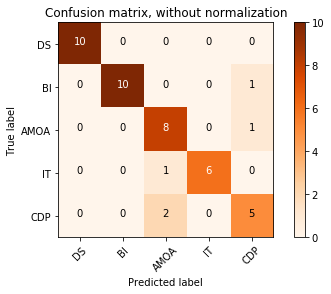

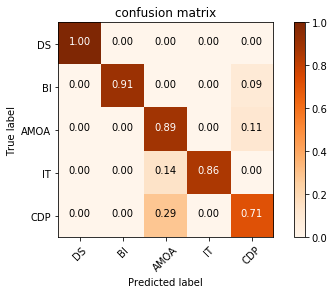

In [339]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix

np.set_printoptions(precision=2)
class_names = ["DS","BI","AMOA","IT","CDP"]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='confusion matrix')

plt.show()

In [211]:
bow_idf_talan.shape

(215, 934)

### SEMI- SUPERVISED- Applied to BOW-IDF -> NMF

In [259]:
bow_idf_reduced_nmf_talan = get_Bow_NMF(bow_idf_talan,nmf_number=50)
df_target_nmf_talan = prepare_bow_with_labels(bow_idf_reduced_nmf_talan[0],np.array(cv_fr_names_talan),df_labels_talan)
df_target_nmf_talan.shape

CV count : 215
After jointure: Nb CV without any label: 72
After jointure: Nb CV with label : 106
After jointure: Nb CV with label= -1: 109


(215, 52)

In [260]:
column_names_talan_nmf = df_target_nmf_talan.columns.values[:-2].tolist()
data_talan = df_target_nmf_talan[column_names_talan_nmf].values
target_talan = df_target_nmf_talan['CV_Label'].values
labelSpreadModel_talan_nmf = trainEval_semi_supervisedModel_balancedClasses(data_talan,target_talan,0.6)


Label Spreading model: 62 labeled & 44 unlabeled points (106 total)
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       1.00      0.55      0.71        11
          4       0.47      0.78      0.58         9
          6       0.70      1.00      0.82         7
          7       0.67      0.29      0.40         7

avg / total       0.79      0.73      0.72        44

Confusion matrix
[[10  0  0  0  0]
 [ 0  6  3  2  0]
 [ 0  0  7  1  1]
 [ 0  0  0  7  0]
 [ 0  0  5  0  2]]


### Label prediction using BOW-IDF 

In [261]:
column_names_talan = df_target_talan_idf.columns.values[:-2].tolist()
X = df_target_talan_idf[column_names_talan][df_target_talan_idf['CV_Label'] ==-1].values
y_predict_talan = labelSpreadModel_talan_idf.predict(X)
indices_unl = np.argwhere(df_target_talan_idf['CV_Label'] ==-1)
#print(y_predict_talan)
indices_unl.flatten().shape
print(labelSpreadModel_talan_idf.transduction_[indices_unl.flatten()])


[7 2 6 2 2 2 7 4 7 4 6 1 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 2 1 4 2 1 6 2 1 4 2 7 6 2 2 1 1 1 1 1 1 2 6 2 7 6 2 2 2 2 6 7 2
 7 4 6 7 2 2 7 4 2 7 2 7 2 7 2 4 7 4 6 6 7 7 4 4 7 6 4 4 6 2 6 4 6 4 2]


####  Les classes dse CVs Talan

In [262]:
cv_classes_talan = np.sort(df_labels_talan.CV_Label.unique())
print("les labels: ", cv_classes_talan)
cv_classeName_talan = ["NA","data_scientist","BI","AMOA","IT","Chef_de_projet"]
print("les noms des classes:", cv_classeName_talan)

les labels:  [-1  1  2  4  6  7]
les noms des classes: ['NA', 'data_scientist', 'BI', 'AMOA', 'IT', 'Chef_de_projet']


In [193]:
# Construction d'un dictionnaire de nombre de Cvs par classe 

dict_res_talan = dict()
i=1
for classe in cv_classes_talan[1:]:
    print(cv_classeName_talan[i])
    dict_res_talan[cv_classeName_talan[i]] = np.where(y_predict_talan == classe)[0].shape[0]
    i+=1
dict_res_talan

data_scientist
BI
AMOA
IT
Chef_de_projet


{'AMOA': 14, 'BI': 50, 'Chef_de_projet': 16, 'IT': 15, 'data_scientist': 14}

In [131]:
df_target_talan_idf[df_target_talan_idf['CV_Label'] == -1].shape
y_predict_talan.shape

(109,)

In [134]:

df_cv_talan_label = df_target_talan_idf.copy()
index_row_talan = df_cv_talan_label.index[df_cv_talan_label['CV_Label']== -1]

#df_cv_talan_label.loc[index_row_talan,'CV_Label'].shape

df_cv_talan_label.loc[index_row_talan,'CV_Label'] = y_predict_talan

df_cv_talan_label.shape


(215, 936)

In [174]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file(filename):
   
    path_data = "./Data_talan_input/"
    paths = [path_data+directory for directory in os.listdir(path_data)]
  
    file_found = 0
  
    for path in paths:
        if exists(join(path, filename)):
            file_found = 1
            break
    if file_found:
        return os.path.abspath(join(path, filename))
    else:
        return None

def copy_file(fileName,directory):
    print("Copy File name", fileName)
    print("to Directory", directory)
    file = search_file(fileName)
    #print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
        return True
    
    return False

In [263]:
path_cv_predict = "./Data_label/prediction_talan/"
i=0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print(label)
    print(classe)
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_talan_label[df_cv_talan_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        
        file_name = cv_name.split('/')[-1][0:-4] + ".docx"
        if copy_file(file_name,directory_class) != True:
            file_name = cv_name.split('/')[-1][0:-4] + ".doc"
            if copy_file(file_name,directory_class) != True:
                print("classe %s; file not found %s" % (directory_class,file_name))
        #open(fileName, 'a').close()
    i+=1
      

1
data_scientist
Copy File name CV HME_TS2017.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_BD_2.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_1.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_10.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_11.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_12.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_13.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_14.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_15.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_16.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_2.docx
to Directory ./Data_label/prediction_talan/data_scientist
Copy File name CV_DS_3.d

Copy File name JCOCV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name LNTCV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name MHMCV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name NAJCV ALJANE.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name NGACV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name NGUE.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name NGUE.doc
to Directory ./Data_label/prediction_talan/IT
Copy File name NSACV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name OUAA.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name OUAA.doc
to Directory ./Data_label/prediction_talan/IT
Copy File name RHICV TALAN.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name SADO.docx
to Directory ./Data_label/prediction_talan/IT
Copy File name SADO.doc
to Directory ./Data_label/prediction_talan/IT
Copy File name SBOU.docx
to Di

In [206]:
i=0
count =0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print("classe: %s ; nb CV: %d" % (classe, df_cv_talan_label[df_cv_talan_label['CV_Label']==label].shape[0]))
    count+= df_cv_talan_label[df_cv_talan_label['CV_Label']==label].shape[0]
    i+=1
print( 'Total count: ', count)

classe: data_scientist ; nb CV: 39
classe: BI ; nb CV: 77
classe: AMOA ; nb CV: 35
classe: IT ; nb CV: 31
classe: Chef_de_projet ; nb CV: 33
Total count:  215


### Prediction CV names .txt

In [269]:
from os.path import exists, join
import shutil
#shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext') # complete target filename given
#shutil.copy2('/src/file.ext', '/dst/dir') # target filen
def search_file_intxtDirectory(filename):
   
    path_data = "./Data_talan/txt/"
     


    if exists(join(path_data, filename)):
        return os.path.abspath(join(path_data, filename))
    else:
        return None

def copy_file_fromtxtDirectory(fileName,directory):
    print("Copy File name", fileName)
    print("to Directory", directory)
    file = search_file_intxtDirectory(fileName)
    #print("File ", file)
    if file !=None :
        shutil.copy2(file, directory)
        return True
    
    return False

In [270]:
path_cv_predict = "./Data_label/prediction_talan_txt/"
i=0
for classe in list(dict_res_talan.keys()):
    label = cv_classes_talan [i+1]
    print(label)
    print(classe)
    directory_class = path_cv_predict + classe
    if not os.path.exists(directory_class):
        os.makedirs(directory_class)
    for cv_name in df_cv_talan_label[df_cv_talan_label['CV_Label']==label]['CV_name'].values:
        #fileName = directory_class + "/" + cv_name
        
        file_name = cv_name.split('/')[-1][0:-4] + ".docx"
        if copy_file_fromtxtDirectory(file_name,directory_class) != True:
            file_name = cv_name
            if copy_file_fromtxtDirectory(file_name,directory_class) != True:
                print("classe %s; file not found %s" % (directory_class,file_name))
        #open(fileName, 'a').close()
    i+=1
      

1
data_scientist
Copy File name CV HME_TS2017.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV HME_TS2017.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_BD_2.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_BD_2.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_1.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_1.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_10.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_10.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_11.docx
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_11.txt
to Directory ./Data_label/prediction_talan_txt/data_scientist
Copy File name CV_DS_12.docx
to Directory ./Data_label/prediction_talan_

to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BLACV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BOA.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BOA.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BPUCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name BPUCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CAPCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CAPCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CHEK.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CHEK.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CLSCV TALAN.docx
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CLSCV TALAN.txt
to Directory ./Data_label/prediction_talan_txt/AMOA
Copy File name CV_ETL_3.docx
to Directory ./Data_label/predi